# 环境配置

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from time import sleep
import math
from scipy.stats import chi2
import scipy
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 数据导入

In [181]:
# 训练集数据导入
train = pd.read_csv('/Users/soyo/Downloads/工作/波行打工/202208/202208-05/银行客户认购产品预测/train的副本.csv')

# 测试集数据导入
test = pd.read_csv('/Users/soyo/Downloads/工作/波行打工/202208/202208-05/银行客户认购产品预测/test.csv')

## 数据情况

In [97]:
# 数据类型查看
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                22500 non-null  int64  
 1   age               22500 non-null  int64  
 2   job               22500 non-null  object 
 3   marital           22500 non-null  object 
 4   education         22500 non-null  object 
 5   default           22500 non-null  object 
 6   housing           22500 non-null  object 
 7   loan              22500 non-null  object 
 8   contact           22500 non-null  object 
 9   month             22500 non-null  object 
 10  day_of_week       22500 non-null  object 
 11  duration          22500 non-null  int64  
 12  campaign          22500 non-null  int64  
 13  pdays             22500 non-null  int64  
 14  previous          22500 non-null  int64  
 15  poutcome          22500 non-null  object 
 16  emp_var_rate      22500 non-null  float6

In [98]:
# 缺失值
train.isnull().sum()

id                  0
age                 0
job                 0
marital             0
education           0
default             0
housing             0
loan                0
contact             0
month               0
day_of_week         0
duration            0
campaign            0
pdays               0
previous            0
poutcome            0
emp_var_rate        0
cons_price_index    0
cons_conf_index     0
lending_rate3m      0
nr_employed         0
subscribe           0
dtype: int64

In [99]:
# 数据unknown
train.isin(['unknown']).mean()*100

id                   0.000000
age                  0.000000
job                  1.217778
marital              1.422222
education            4.417778
default             21.600000
housing              3.937778
loan                 3.951111
contact              0.000000
month                0.000000
day_of_week          0.000000
duration             0.000000
campaign             0.000000
pdays                0.000000
previous             0.000000
poutcome             0.000000
emp_var_rate         0.000000
cons_price_index     0.000000
cons_conf_index      0.000000
lending_rate3m       0.000000
nr_employed          0.000000
subscribe            0.000000
dtype: float64

In [100]:
# 用众数填充未知值
train['default'].replace(['unknown'],train['default'].mode(),inplace=True)
train['education'].replace(['unknown'],train['education'].mode(),inplace=True)
train['marital'].replace(['unknown'],train['marital'].mode(),inplace=True)
train['job'].replace(['unknown'],train['job'].mode(),inplace=True)
train['housing'].replace(['unknown'],train['housing'].mode(),inplace=True)
train['loan'].replace(['unknown'],train['loan'].mode(),inplace=True)
train.drop(['id'],inplace=True,axis=1)

In [101]:
train.isin(['unknown']).mean()*100

age                 0.0
job                 0.0
marital             0.0
education           0.0
default             0.0
housing             0.0
loan                0.0
contact             0.0
month               0.0
day_of_week         0.0
duration            0.0
campaign            0.0
pdays               0.0
previous            0.0
poutcome            0.0
emp_var_rate        0.0
cons_price_index    0.0
cons_conf_index     0.0
lending_rate3m      0.0
nr_employed         0.0
subscribe           0.0
dtype: float64

In [102]:
# 检测是否有重复值
train.duplicated().all()
# train_db = train.drop_duplicates() 

False

In [182]:
# 划分数字特征与非数字特征
cat_features = [x for x in train.columns if train[x].dtype == object and x!= 'subscribe']
num_features = [x for x in train.columns if train[x].dtype != object]
    
train[num_features].describe()

,id,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_index,cons_conf_index,lending_rate3m,nr_employed
count,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000
mean,11250.500000,40.407511,1146.303733,3.364800,773.991956,1.316444,0.078529,93.548785,-39.877180,3.302490,5137.211285
std,6495.334864,12.086078,1432.432125,7.223837,326.934334,1.918733,1.573831,2.805786,5.805442,1.611777,170.670611
min,1.000000,16.000000,0.000000,0.000000,0.000000,0.000000,-3.400000,87.640000,-53.280000,0.600000,4715.420000
25%,5625.750000,32.000000,143.000000,1.000000,557.750000,0.000000,-1.800000,91.190000,-44.160000,1.430000,5008.510000
50%,11250.500000,38.000000,353.000000,1.000000,964.000000,0.000000,1.100000,93.540000,-40.600000,3.920000,5133.955000
75%,16875.250000,47.000000,1873.000000,3.000000,1005.000000,2.000000,1.400000,95.920000,-35.797500,4.830000,5267.677500
max,22500.000000,101.000000,5149.000000,57.000000,1048.000000,6.000000,1.400000,99.460000,-25.550000,5.270000,5489.500000


In [183]:
# 四分位数法数据清洗
for column in num_features:
    temp = train[column]
    q1 = temp.quantile(0.25)
    q2 = temp.quantile(0.75)
    delta = (q1 - q2) * 1.5
    train[column] = np.clip(temp, q1-delta, q2+delta)
    #clip函数将数组中的元素限制在a_min, a_max之间，大于a_max的就使得它等于 a_max，小于a_min,的就使得它等于a_min

train[num_features].describe()

,id,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_index,cons_conf_index,lending_rate3m,nr_employed
count,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000
mean,11250.500000,39.417822,945.906489,1.745867,803.944911,0.969689,0.078529,93.548694,-40.035170,3.302490,5137.897790
std,6495.334864,9.394345,1037.763507,1.383856,268.683852,1.259999,1.573831,2.767938,5.214026,1.611777,159.273557
min,1.000000,24.500000,0.000000,0.000000,334.125000,0.000000,-3.400000,88.825000,-48.341250,0.600000,4878.926250
25%,5625.750000,32.000000,143.000000,1.000000,557.750000,0.000000,-1.800000,91.190000,-44.160000,1.430000,5008.510000
50%,11250.500000,38.000000,353.000000,1.000000,964.000000,0.000000,1.100000,93.540000,-40.600000,3.920000,5133.955000
75%,16875.250000,47.000000,1873.000000,3.000000,1005.000000,2.000000,1.400000,95.920000,-35.797500,4.830000,5267.677500
max,22500.000000,54.500000,2738.000000,4.000000,1048.000000,3.000000,1.400000,98.285000,-31.616250,5.270000,5397.261250


In [105]:
for column in cat_features:
    print(train[column].value_counts(),'\n------')

admin.           5831
blue-collar      4874
technician       3530
services         2083
management       1600
retired          1006
entrepreneur      863
self-employed     836
housemaid         657
unemployed        647
student           573
Name: job, dtype: int64 
------
married     13498
single       6344
divorced     2658
Name: marital, dtype: int64 
------
university.degree      7518
high.school            5031
basic.9y               3266
professional.course    2853
basic.4y               2322
basic.6y               1349
illiterate              161
Name: education, dtype: int64 
------
no     22121
yes      379
Name: default, dtype: int64 
------
yes    12454
no     10046
Name: housing, dtype: int64 
------
no     18843
yes     3657
Name: loan, dtype: int64 
------
cellular     14181
telephone     8319
Name: contact, dtype: int64 
------
may    7235
jul    3815
aug    3340
jun    2838
nov    2242
apr    1510
oct     494
mar     426
sep     401
dec     199
Name: month, dtype: int64

In [ ]:
# 异常值箱线图
train_x.boxplot(widths=0.5,column = ['age',
 'campaign',
'previous'])

In [ ]:
# 异常值处理 https://www.cnblogs.com/hider/p/14733463.html
# 95分位盖帽法
def blk(floor, root): 
    def f(x):       
        if x < floor:
            x = floor
        elif x > root:
            x = root
        return x
    return f

# 清洗数据
train_x['duration'] = train_x['duration'].map(blk(0, root=train_x['duration'].quantile(0.99))) 

# 缺失值填充
train_x['duration'] = train_x['duration'].fillna(0)
train_x['age'] = train_x['age'].map(blk(0, root=train_x['age'].quantile(0.99))) 
train_x['campaign'] = train_x['campaign'].map(blk(0, root=train_x['campaign'].quantile(0.99))) 

<AxesSubplot:>

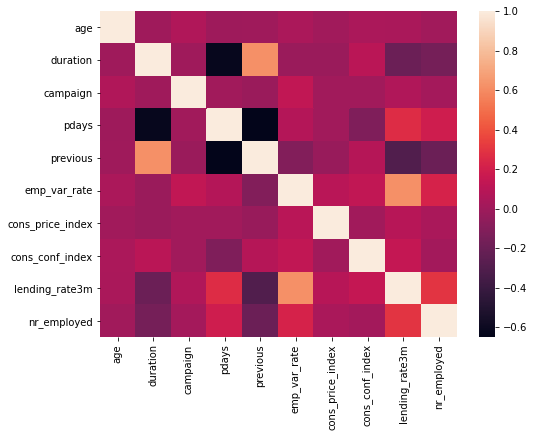

In [106]:
# 查看各特征之间的相关性
plt.figure(figsize=(8,6))
sns.heatmap(train.corr())

In [174]:
# 获取x,y
X=train.drop('subscribe',axis=1)
y=train.loc[:,'subscribe']

In [175]:
# 对于有限的分类变量做onehot编码处理
cate=X.columns[X.dtypes=='object']
X=X.join(pd.get_dummies(X[cate])).drop(cate,axis=1)
X.head()

ValueError: No objects to concatenate

In [137]:
# 对测试集做编码处理
test = pd.read_csv('/Users/soyo/Downloads/工作/波行打工/202208/202208-05/银行客户认购产品预测/test.csv')

test['default'].replace(['unknown'],test['default'].mode(),inplace=True)
test['education'].replace(['unknown'],test['education'].mode(),inplace=True)
test['marital'].replace(['unknown'],test['marital'].mode(),inplace=True)
test['job'].replace(['unknown'],test['job'].mode(),inplace=True)
test['housing'].replace(['unknown'],test['housing'].mode(),inplace=True)
test['loan'].replace(['unknown'],test['loan'].mode(),inplace=True)

test_cate=test.columns[test.dtypes=='object']
test=test.join(pd.get_dummies(test[test_cate])).drop(test_cate,axis=1)

test=test.drop('id',axis=1)
test.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_index,cons_conf_index,lending_rate3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,35,3295,1,476,0,1.4,95.37,-33.04,3.63,5204.54,...,0,0,0,1,0,0,0,0,0,1
1,26,2872,1,166,2,-1.8,91.75,-44.42,3.16,4924.78,...,0,0,0,0,1,0,0,0,0,1
2,44,268,3,968,0,1.1,89.67,-36.90,5.04,4947.02,...,0,0,0,1,0,0,0,0,1,0
3,36,30,1,432,5,-0.1,89.87,-41.66,3.27,5203.33,...,0,0,0,0,1,0,0,0,0,1
4,41,1670,1,944,3,1.1,97.64,-36.32,3.95,4992.02,...,0,0,0,0,1,0,0,0,0,1


In [115]:
# 样本严重不均衡，所以用上采样处理
X,y = SMOTE().fit_resample(X,y)
y.value_counts()

yes    19548
no     19548
Name: subscribe, dtype: int64

# 变量分箱

In [ ]:
def CalcWOE(df, col, target):
    '''
    : df dataframe
    : col 注意这列已经分过箱了，现在计算每箱的WOE和总的IV
    ：target 目标列 0-1值
    ：return 返回每箱的WOE和总的IV
    '''
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].count() - df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    regroup['good'] = regroup['total'] - regroup['bad']
    G = N - B
    regroup['bad_pcnt'] = regroup['bad'].map(lambda x: x * 1.0 / B)
    regroup['good_pcnt'] = regroup['good'].map(lambda x: x * 1.0 / G)
    regroup['WOE'] = regroup.apply(
        lambda x: np.log(x.good_pcnt * 1.0 / x.bad_pcnt), axis=1)
    WOE_dict = regroup[[col, 'WOE']].set_index(col).to_dict(orient='index')
    IV = regroup.apply(
        lambda x:
        (x.good_pcnt - x.bad_pcnt) * np.log(x.good_pcnt * 1.0 / x.bad_pcnt),
        axis=1)
    IV_SUM = sum(IV)
    return {'WOE': WOE_dict, 'IV_sum': IV_SUM, 'IV': IV}

#判断woe是否满足单调性
def BadRateMonotone(df, sortByVar, target):
    #df[sortByVar]这列已经经过分箱
    df2 = df.sort_values(by=[sortByVar])
    total = df2.groupby([sortByVar])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df2.groupby([sortByVar])[target].count() - df2.groupby(
        [sortByVar])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    combined = zip(regroup['total'], regroup['bad'])
    badRate = [x[1] * 1.0 / x[0] for x in combined]
    badRateMonotone = [
        badRate[i] < badRate[i + 1] for i in range(len(badRate) - 1)
    ]
    Monotone = len(set(badRateMonotone))
    if Monotone == 1:
        return True
    else:
        return False


def num_band(df, columns, target, min_num, max_num):
    result = []
    for col in columns:
        for i in range(min_num, max_num):
            try:
                df['band'] = pd.cut(df[col], i)
                WOE_IV = CalcWOE(df, 'band', target)
                T_F = BadRateMonotone(df, 'band', target)
                result.append([col, i, WOE_IV['IV_sum'], T_F])
            except:
                continue
    return pd.DataFrame(result, columns=['column', 'num', 'IV_sum', 'T_F'])


num_band(train_set, num_columns, 'y', 2, 10)
#选择woe满足单调性且IV值最大的分箱数量
for dataset in [train_set]:
    dataset['balanceBin'] = pd.qcut(dataset['balance'], 5)
    dataset['ageBin'] = pd.cut(dataset['age'].astype(int), [0, 30, 60, 100])
    dataset['quarter'] = dataset['month'].map(quarter)
    dataset['halfyear'] = dataset['month'].map(halfyear)
    dataset['dayBin'] = pd.cut(dataset['day'], 2)
    dataset['durationBin'] = pd.qcut(dataset['duration'], 9)
    dataset['campaignBin'] = pd.qcut(dataset['campaign'], 2)
    dataset['pdaysBin'] = pd.cut(dataset['pdays'], 9)
    dataset['previousBin'] = pd.cut(dataset['previous'], 9)
    dataset['all_previous'] = dataset['campaign'] + dataset['previous']
    dataset['all_previousBin'] = pd.cut(dataset['all_previous'], 2)

# 逻辑回归

In [129]:
#逻辑回归

param = {"penalty": ["l1", "l2", ], "C": [0.1, 1, 10], "solver": ["liblinear","saga"]}
gs = GridSearchCV(estimator=LogisticRegression(), param_grid=param, cv=2, scoring="f1", n_jobs=-1, verbose=10) 
gs.fit(X, y) 
print(gs.best_params_) 

Fitting 2 folds for each of 12 candidates, totalling 24 fits
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [157]:
# 结果导出
y_pred = gs.best_estimator_.predict(test) 

result = pd.read_csv('/Users/soyo/Downloads/工作/波行打工/202208/202208-05/银行客户认购产品预测/submission.csv')
result['subscribe'] = y_pred
result.to_csv('/Users/soyo/Downloads/工作/波行打工/202208/202208-05/银行客户认购产品预测/submission_lr3.csv')

# 随机森林

In [160]:
# 随机森林
param = {"criterion": ["gini", "entropy"], "max_depth": [10, 15] } 
gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param, cv=2, scoring="f1", n_jobs=-1, verbose=10) 
gs.fit(X, y) 
print(gs.best_params_) 

Fitting 2 folds for each of 4 candidates, totalling 8 fits
{'criterion': 'gini', 'max_depth': 10}


In [161]:
y_pred = gs.best_estimator_.predict(test) 

result = pd.read_csv('/Users/soyo/Downloads/工作/波行打工/202208/202208-05/银行客户认购产品预测/submission.csv')
result['subscribe'] = y_pred
result.to_csv('/Users/soyo/Downloads/工作/波行打工/202208/202208-05/银行客户认购产品预测/submission_rf.csv')

# XGBoost
利用XGBoost算法进行建模时无需对数据进行标准化处理    
1、神器xgboost简单入门和运用https://blog.csdn.net/qq_36142114/article/details/80515721   
2、深入理解XGBoosthttps://mp.weixin.qq.com/s/HDEKnIufbW8xQcOgHaXlZw    
3、xgboost使用之前是否需要对数据进行归一化处理 或者 ONEHOT处理?https://www.zhihu.com/question/60630393

In [184]:
for col in cat_features:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
le_label = LabelEncoder()
train_y = le_label.fit_transform(train['subscribe'])

In [185]:
# 网格调参
from xgboost import XGBClassifier
learning_rate = [0.05,0.1,0.15,0.2]
subsample = [0.7,0.8,0.9]
colsample_bytree = [0.7,0.8,0.9]
max_depth = [2,3,4,5,6,7,8]

parameter = {'learning_rate':learning_rate,
            'subsample':subsample,
            'colsample_bytree':colsample_bytree,
            'max_depth':max_depth}
model = XGBClassifier(n_estimators = 50)

In [186]:
# 训练
data_target_part = train_y
data_features_part = train[[x for x in train.columns if x != 'subscribe']]
clf = GridSearchCV(model,parameter,cv=3,scoring='accuracy',verbose=1,n_jobs=-1)
clf.fit(data_features_part, data_target_part)

Fitting 3 folds for each of 252 candidates, totalling 756 fits
[17:16:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=50, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=1)

In [180]:
# 测试并保存结果
test['subscribe'] = le_label.inverse_transform(clf.predict(test))
result = test['subscribe']
result.to_csv('/Users/soyo/Downloads/工作/波行打工/202208/202208-05/银行客户认购产品预测/submission_xgb1.csv')

ValueError: feature_names mismatch: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_index', 'cons_conf_index', 'lending_rate3m', 'nr_employed', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success'] ['id', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_index', 'cons_conf_index', 'lending_rate3m', 'nr_employed']
expected month_sep, day_of_week_wed, day_of_week_thu, poutcome_success, day_of_week_fri, education_illiterate, contact_cellular, housing_no, job_unemployed, job_retired, month_jul, poutcome_failure, education_basic.6y, education_professional.course, education_university.degree, month_jun, job_blue-collar, job_student, marital_divorced, loan_yes, day_of_week_mon, job_housemaid, contact_telephone, month_mar, education_high.school, month_aug, month_apr, month_oct, job_admin., job_technician, default_yes, job_services, default_no, job_entrepreneur, job_management, job_self-employed, month_dec, poutcome_nonexistent, marital_married, education_basic.4y, day_of_week_tue, loan_no, month_nov, education_basic.9y, month_may, marital_single, housing_yes in input data
training data did not have the following fields: poutcome, job, day_of_week, month, id, housing, marital, contact, default, education, loan

In [179]:
metrics.accuracy_score()
#lift, iv, ks，决策树深度

0         no
1        yes
2         no
3        yes
4         no
        ... 
22495    yes
22496     no
22497     no
22498     no
22499    yes
Name: subscribe, Length: 22500, dtype: object